### LOAD DATA & PREP FOR FMM

In [36]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

# Load splits
df_train = pd.read_csv("../data/cache/poster3_train_graphed.csv")
df_val = pd.read_csv("../data/cache/poster3_val_graphed.csv")
df_test = pd.read_csv("../data/cache/poster3_test.csv")

# Budget column (for labels)
budget_col = "from_budget_category"

# Helper: safely split strings into lists
def split_tags(col):
    return col.fillna("").apply(lambda x: [t.strip() for t in x.split(",") if t.strip()])

# Fit binarizers on training set only
mlb_genre = MultiLabelBinarizer()
mlb_subgenre = MultiLabelBinarizer()
mlb_genre.fit(split_tags(df_train["genres"]))
mlb_subgenre.fit(split_tags(df_train["subgenres"]))

# Function to process each split
def process_split(df):
    # Drop indie budget tier
    df = df[df["from_budget_category"] != "indie"].reset_index(drop=True)
    
    genres = pd.DataFrame(mlb_genre.transform(split_tags(df["genres"])),
                          columns=[f"genre_{g}" for g in mlb_genre.classes_])
    
    subgenres = pd.DataFrame(mlb_subgenre.transform(split_tags(df["subgenres"])),
                             columns=[f"subgenre_{s}" for s in mlb_subgenre.classes_])
    
    numeric = df[[
        "from_runtimeMinutes", 
        "from_averageRating", 
        "from_numVotes",
    ]].reset_index(drop=True)

    # Ensure graph feature columns always exist
    graph_cols = ["degree", "betweenness_m2m"]
    graph_cols2 = ["degree", "betweenness_m2m", "community_id", "community_size"]
    
    for col in graph_cols:
        if col not in df.columns:
            df[col] = 0  # or -1 if you want to flag them as missing
    graph_feats = df[graph_cols].reset_index(drop=True)

    X = pd.concat([numeric, graph_feats, genres, subgenres], axis=1)
    y = df[budget_col].reset_index(drop=True)

    return X, y




# Process each split
X_train_raw, y_train = process_split(df_train)
X_val_raw, y_val = process_split(df_val)
X_test_raw, y_test = process_split(df_test)

# Scale all features based on training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

print("Datasets locked and loaded!")

Datasets locked and loaded!


In [40]:
list(X_train_raw.columns)[:50]

['from_runtimeMinutes',
 'from_averageRating',
 'from_numVotes',
 'degree',
 'betweenness_m2m',
 'genre_Action',
 'genre_Adventure',
 'genre_Animation',
 'genre_Biography',
 'genre_Comedy',
 'genre_Crime',
 'genre_Documentary',
 'genre_Drama',
 'genre_Family',
 'genre_Fantasy',
 'genre_History',
 'genre_Horror',
 'genre_Music',
 'genre_Musical',
 'genre_Mystery',
 'genre_Romance',
 'genre_Sci-Fi',
 'genre_Sport',
 'genre_Thriller',
 'genre_War',
 'genre_Western',
 'subgenre_action-epic',
 'subgenre_alien-invasion-sci-fi',
 'subgenre_alien-invasion-sci-fi-Copy1',
 'subgenre_american-football-sport',
 'subgenre_aquatic-sport',
 'subgenre_artificial-intelligence-sci-fi',
 'subgenre_b-action',
 'subgenre_b-horror',
 'subgenre_baseball-sport',
 'subgenre_basketball-sport',
 'subgenre_body-horror',
 'subgenre_body-swap-comedy',
 'subgenre_boxing-sport',
 'subgenre_buddy-comedy',
 'subgenre_buddy-cop-comedy',
 'subgenre_bumbling-detective-mystery',
 'subgenre_caper-crime',
 'subgenre_car-acti

### RUN FMM FOR DIFFERENT K

In [37]:
from sklearn.mixture import GaussianMixture
import pandas as pd
from collections import Counter

def fit_fmm_with_validation(X_train, X_val, n_components):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_train)

    aic = round(gmm.aic(X_val), 2)
    bic = round(gmm.bic(X_val), 2)
    
    labels = gmm.predict(X_val)
    distribution = dict(Counter(labels))  # {cluster_id: count}

    return {
        "k": n_components,
        "aic": aic,
        "bic": bic,
        "distribution": distribution
    }

# Run for each K
k_list = [20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 200, 500]
results = [fit_fmm_with_validation(X_train, X_val, k) for k in k_list]

perf_df = pd.DataFrame(results)
perf_df.head()

,k,aic,bic,distribution
0,20,7.205688e+08,7.214191e+08,"{4: 35, 16: 25, 0: 30, 7: 51, 5: 17, 3: 5, 2: ..."
1,25,7.918696e+08,7.929324e+08,"{5: 8, 2: 31, 15: 40, 21: 16, 20: 15, 8: 17, 7..."
2,30,7.832972e+08,7.845726e+08,"{5: 20, 2: 23, 15: 42, 21: 17, 20: 10, 8: 11, ..."
3,35,1.067917e+09,1.069405e+09,"{5: 15, 2: 22, 15: 24, 8: 9, 3: 25, 20: 12, 31..."
4,40,1.269748e+09,1.271449e+09,"{5: 14, 2: 17, 15: 24, 8: 10, 39: 6, 36: 2, 31..."


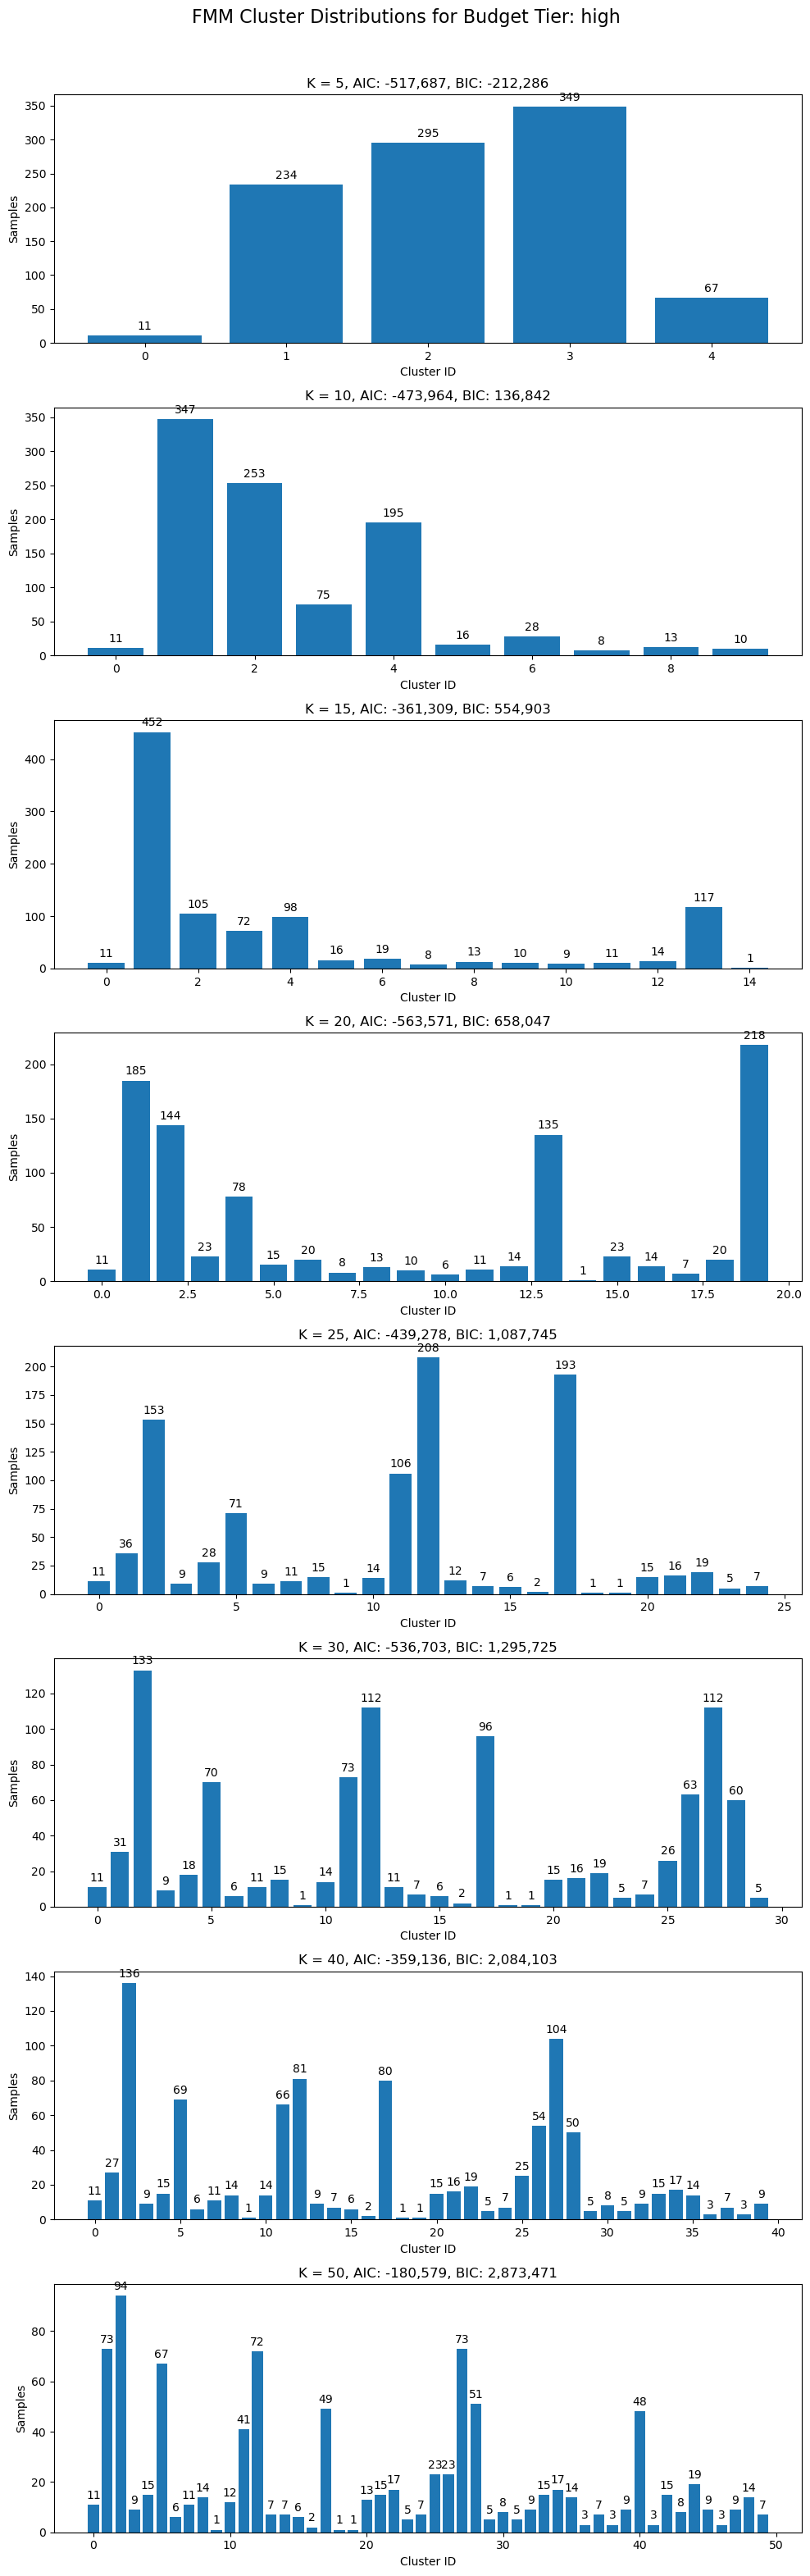

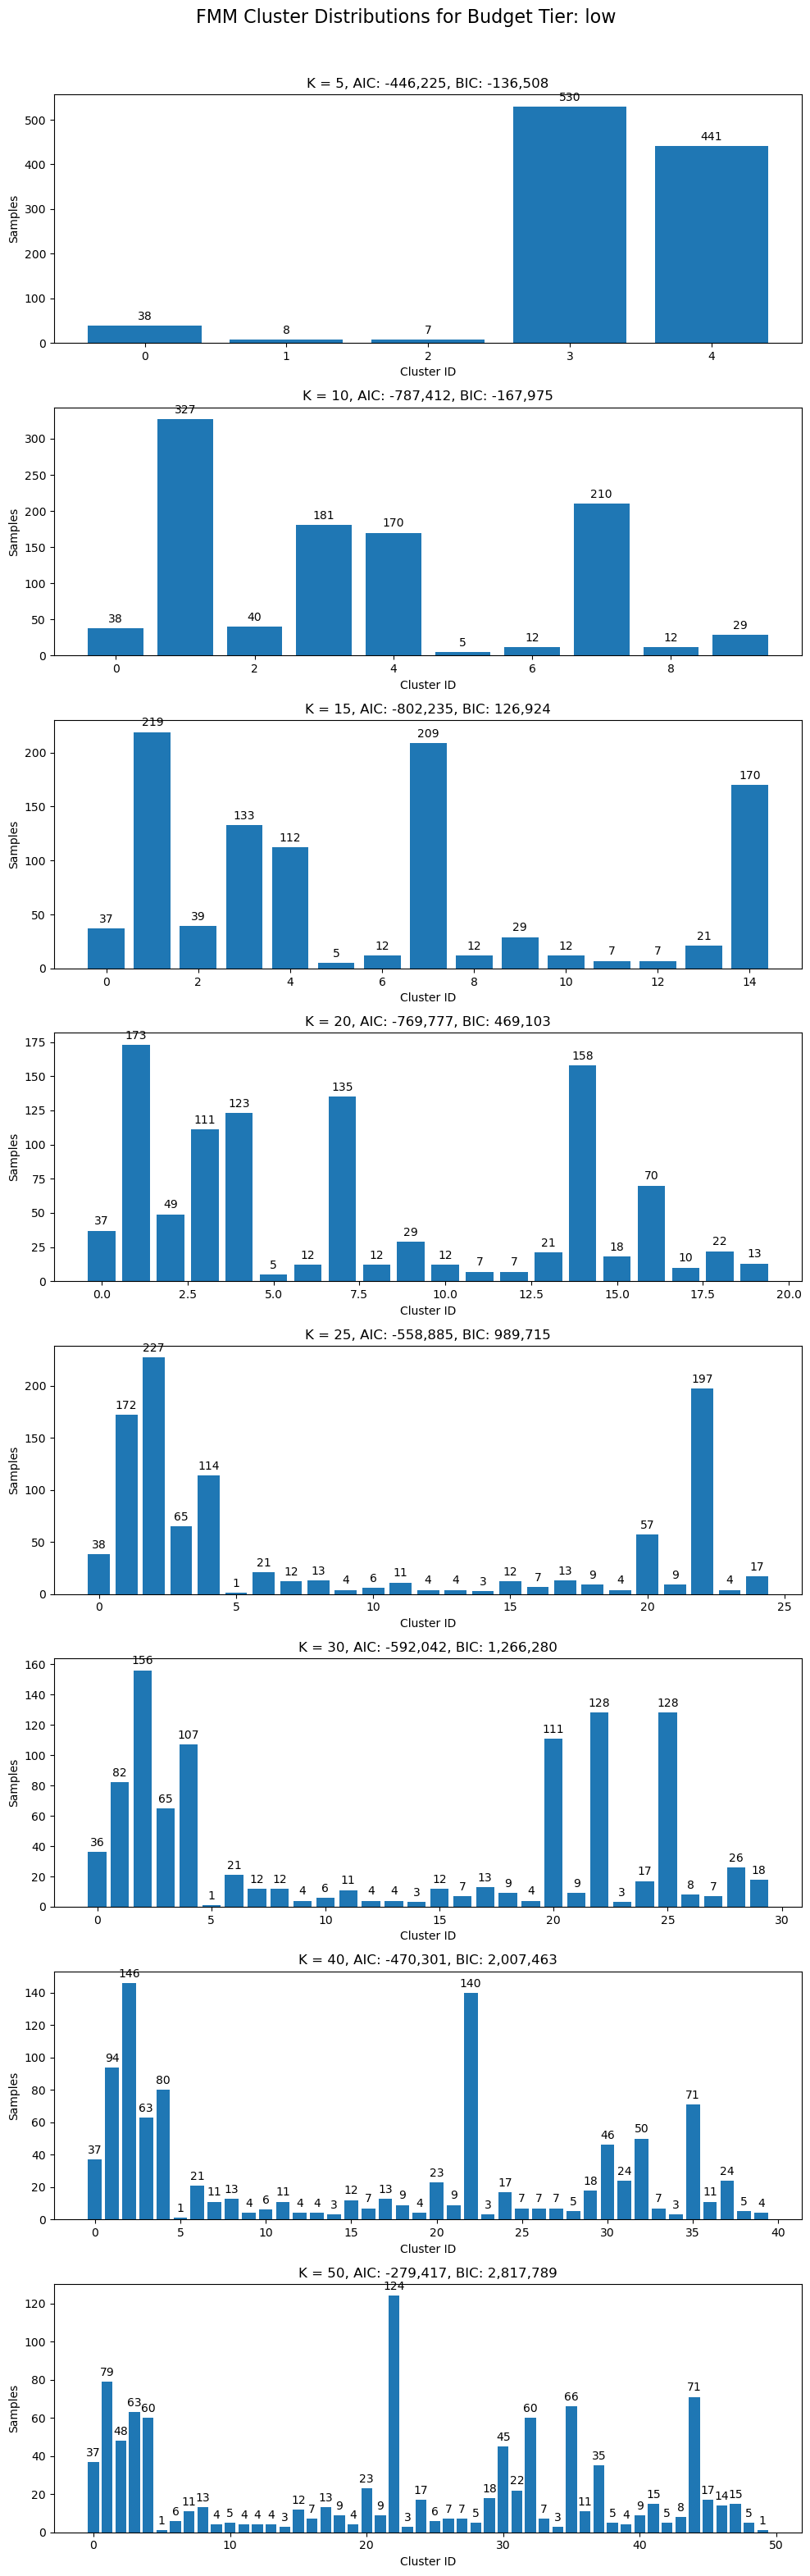

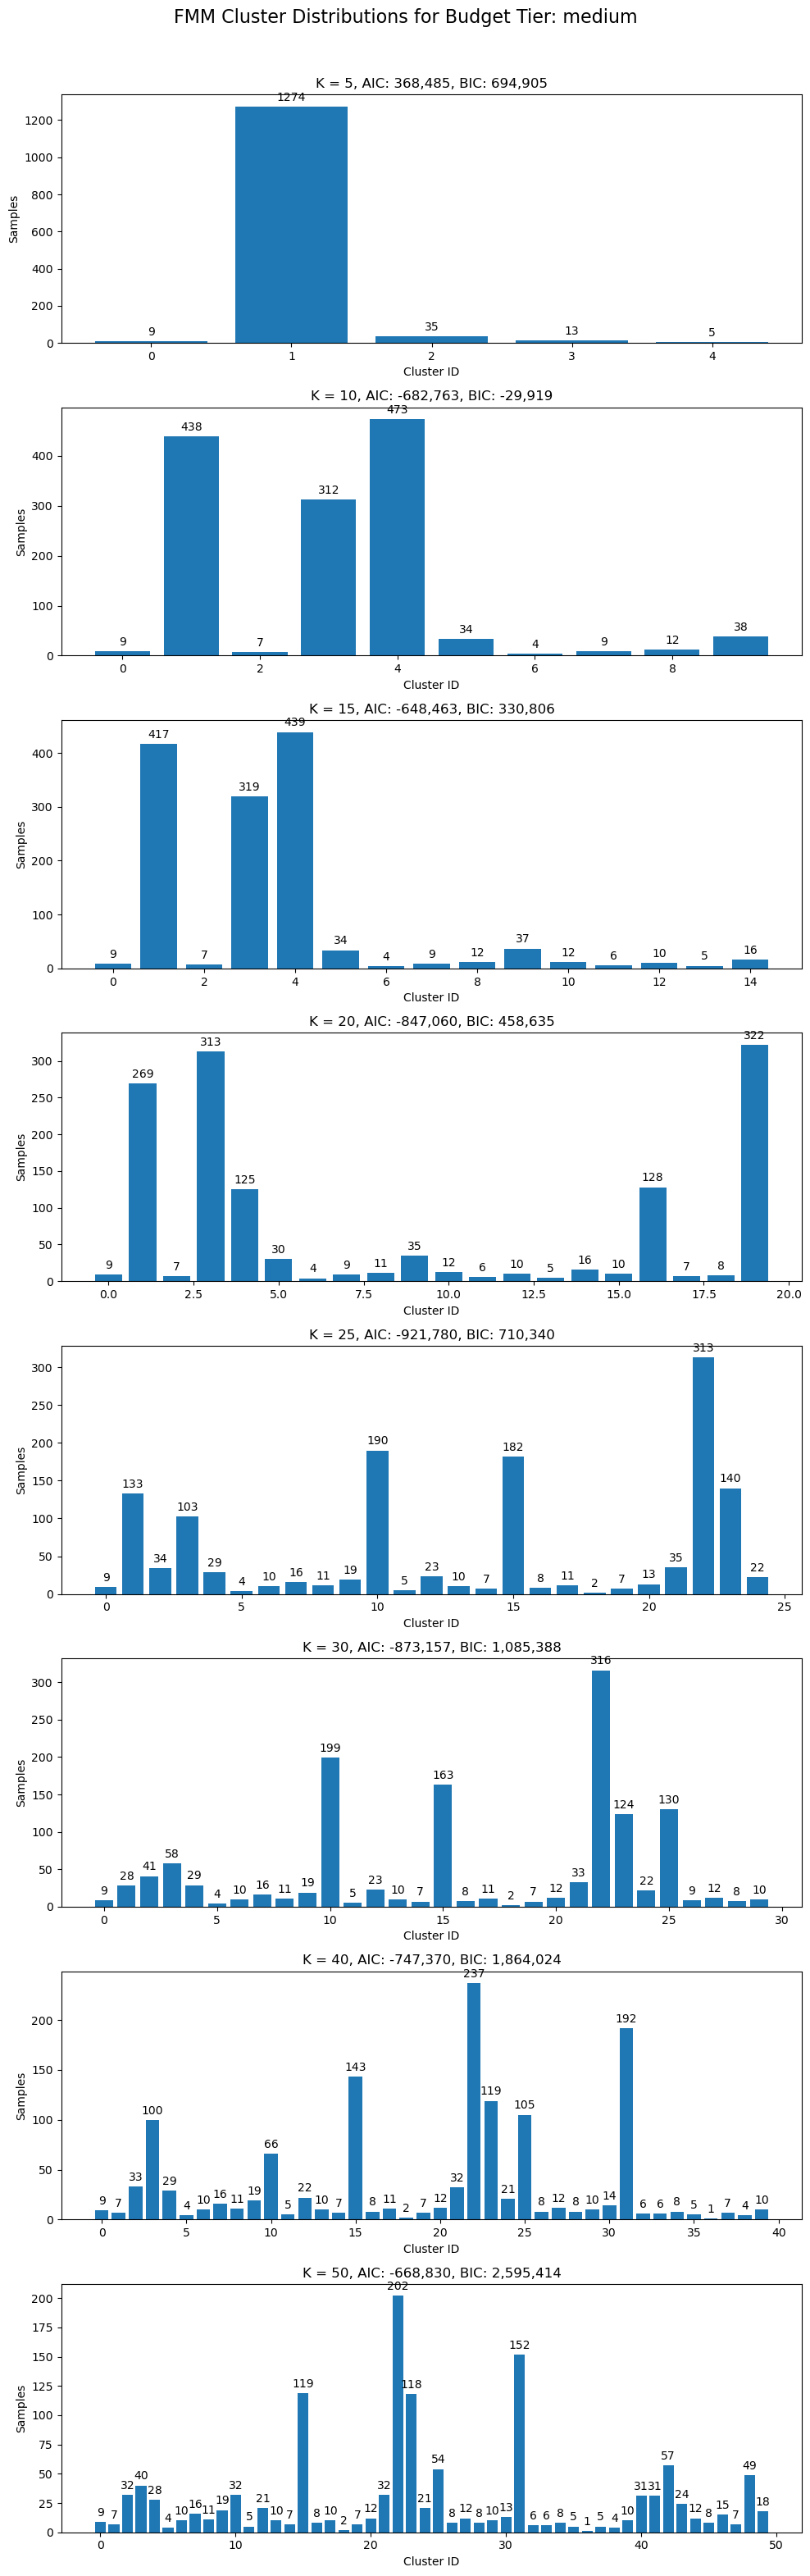

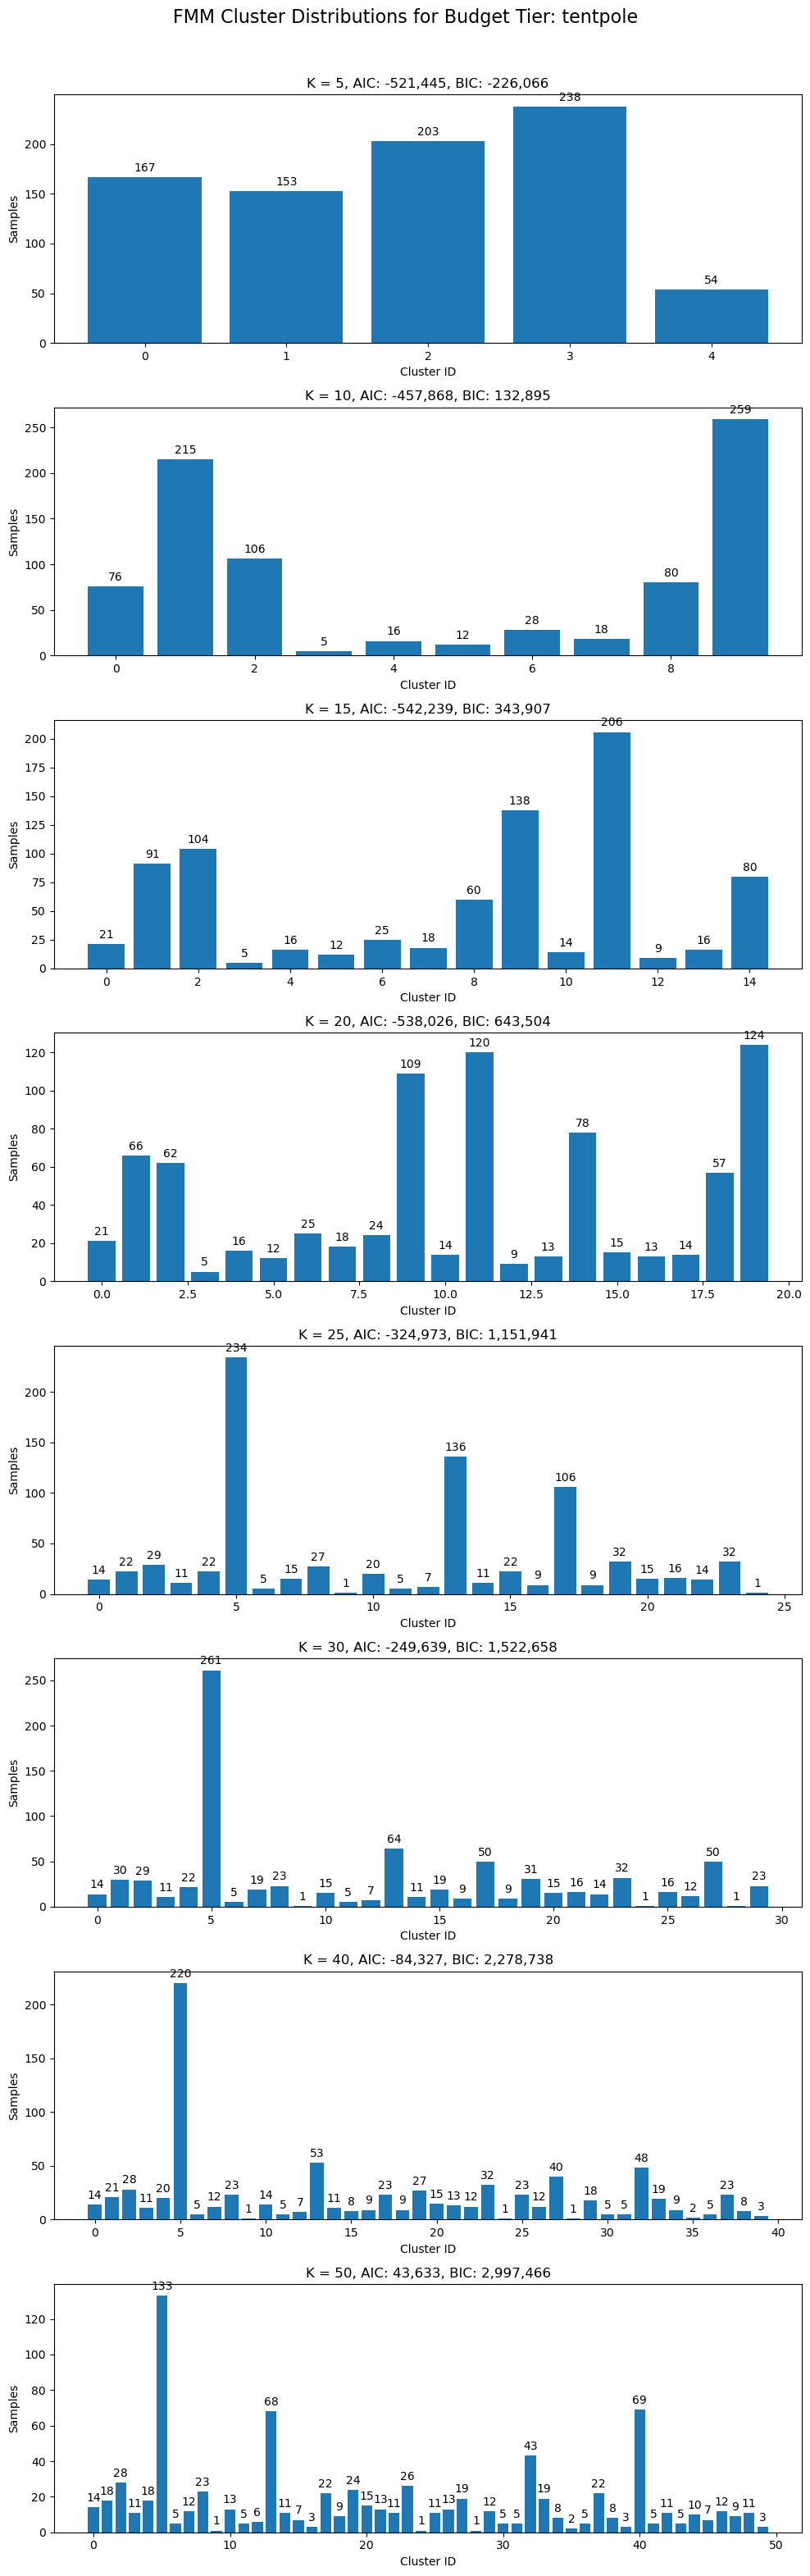

In [39]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from collections import Counter
import warnings
import os

os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings("ignore", category=UserWarning)

# Parameters
k_list = [5, 10, 15, 20, 25, 30, 40, 50]
budget_buckets = sorted(y_train.unique())
full_results = {}

# Fit FMM for each budget tier and K
for bucket in budget_buckets:
    mask = y_train == bucket
    X_bucket = X_train[mask]

    results = []
    for k in k_list:
        if X_bucket.shape[0] < k:
            continue

        gmm = GaussianMixture(n_components=k, random_state=0)
        gmm.fit(X_bucket)

        labels = gmm.predict(X_bucket)
        distribution = dict(Counter(labels))

        results.append({
            "k": k,
            "aic": gmm.aic(X_bucket),
            "bic": gmm.bic(X_bucket),
            "distribution": distribution
        })

    full_results[bucket] = results

# Plot cluster distributions per budget tier
for bucket, results in full_results.items():
    fig, axs = plt.subplots(len(results), 1, figsize=(10, 4 * len(results)), sharex=False)
    fig.suptitle(f"FMM Cluster Distributions for Budget Tier: {bucket}", fontsize=16)

    for i, row in enumerate(results):
        k = row["k"]
        aic = row["aic"]
        bic = row["bic"]
        dist = row["distribution"]

        ax = axs[i]
        bars = ax.bar(dist.keys(), dist.values())
        ax.set_title(f"K = {k}, AIC: {aic:,.0f}, BIC: {bic:,.0f}")
        ax.set_xlabel("Cluster ID")
        ax.set_ylabel("Samples")

        # Annotate each bar
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{int(height)}",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f"../plots/fmm/{bucket}_fmm_cluster_distributions.png")
    plt.show()



In [ ]:
# filter by budget bucket

# Run for each K
k_list = [20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 200, 500]
results = [fit_fmm_with_distribution(X_scaled, k) for k in k_list]

# Turn into a DataFrame for viewing
perf_df = pd.DataFrame(results)

perf_df.head()

In [23]:
X.columns

Index(['from_runtimeMinutes', 'from_averageRating', 'from_numVotes',
       'from_budget', 'from_revenue', 'genre_ ', 'genre_,', 'genre_-',
       'genre_A', 'genre_B', 'genre_C', 'genre_D', 'genre_F', 'genre_H',
       'genre_M', 'genre_R', 'genre_S', 'genre_T', 'genre_W', 'genre_a',
       'genre_c', 'genre_d', 'genre_e', 'genre_g', 'genre_h', 'genre_i',
       'genre_l', 'genre_m', 'genre_n', 'genre_o', 'genre_p', 'genre_r',
       'genre_s', 'genre_t', 'genre_u', 'genre_v', 'genre_y', 'subgenre_ ',
       'subgenre_,', 'subgenre_-', 'subgenre_1', 'subgenre_C', 'subgenre_a',
       'subgenre_b', 'subgenre_c', 'subgenre_d', 'subgenre_e', 'subgenre_f',
       'subgenre_g', 'subgenre_h', 'subgenre_i', 'subgenre_j', 'subgenre_k',
       'subgenre_l', 'subgenre_m', 'subgenre_n', 'subgenre_o', 'subgenre_p',
       'subgenre_q', 'subgenre_r', 'subgenre_s', 'subgenre_t', 'subgenre_u',
       'subgenre_v', 'subgenre_w', 'subgenre_x', 'subgenre_y', 'subgenre_z'],
      dtype='object')

In [26]:
df.columns

Index(['Unnamed: 0', 'from_tconst', 'from_label', 'from_title', 'from_year',
       'from_runtimeMinutes', 'from_averageRating', 'from_numVotes',
       'from_budget', 'from_revenue', 'relationship', 'to_label', 'to_name',
       'to_id', 'to_gender', 'to_popularity', 'to_adult', 'genres',
       'subgenres', 'from_year_adj', 'from_budget_adj', 'from_revenue_adj',
       'from_budget_category', 'profit', 'profit_percent_gain'],
      dtype='object')